**Importing libraries**

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [2]:
stock = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')

In [3]:
stock.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [5]:
stock.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [6]:
#Checking for null values in dataset
stock.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [7]:
stock['Date'] = pd.to_datetime(stock['Date'])
stock.dtypes

Date                    datetime64[ns]
Open                           float64
High                           float64
Low                            float64
Last                           float64
Close                          float64
Total Trade Quantity             int64
Turnover (Lacs)                float64
dtype: object

In [8]:
stock = stock.sort_values('Date')
stock.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


Text(0, 0.5, 'Close')

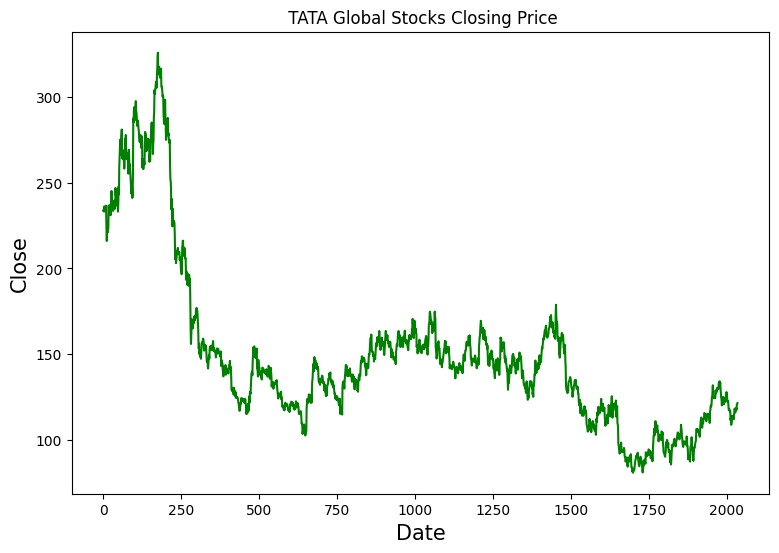

In [9]:
plt.figure(figsize = (9,6))
plt.title(' TATA Global Stocks Closing Price')
plt.plot(stock['Close'],'g')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Close',fontsize=15)

In [10]:
data_close = stock.reset_index()['Close']
data_close.head()

0    121.55
1    120.90
2    120.65
3    117.60
4    118.65
Name: Close, dtype: float64

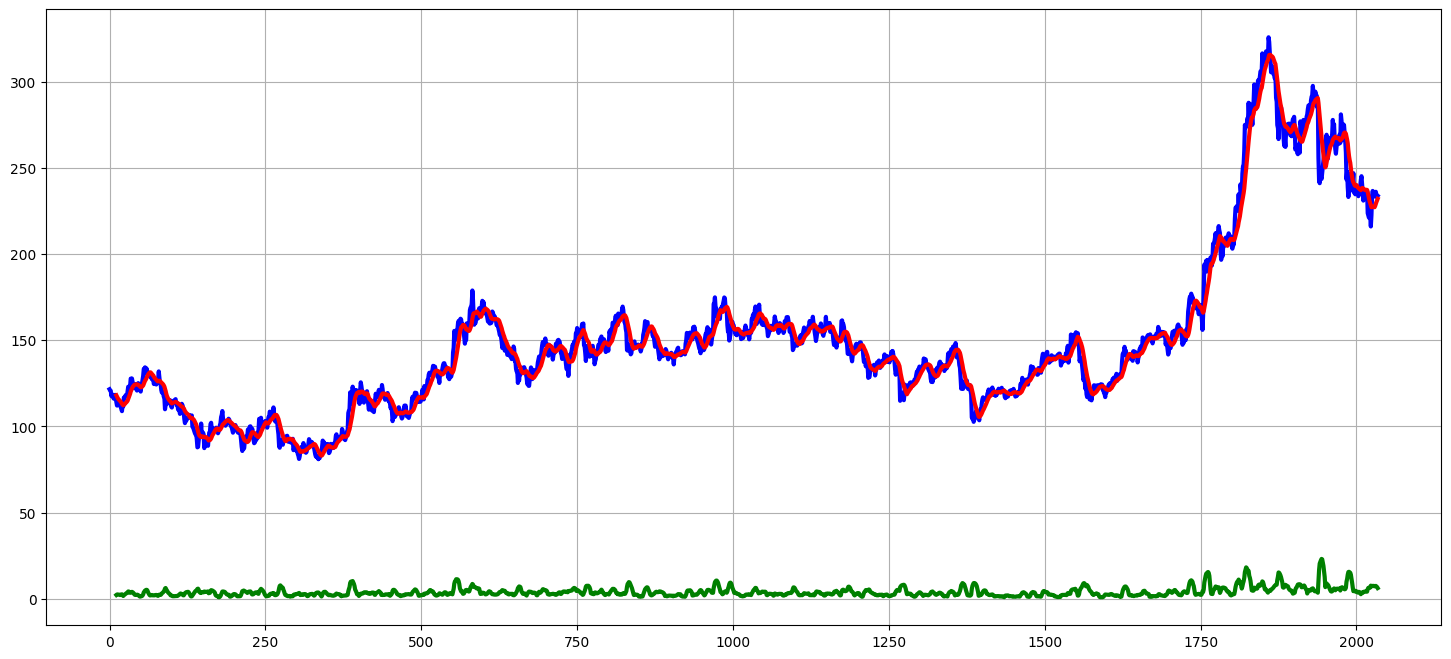

Test Statistics             -0.901358
p-value                      0.787525
No of lags                  16.000000
No of observation used    2018.000000
critical value (1%)         -3.433595
critical value (5%)         -2.862973
critical value (10%)        -2.567533
dtype: float64


In [11]:
from statsmodels.tsa.stattools import adfuller

#Test for stationary
def test_stationary(timeseries):
    rolemean=timeseries.rolling(12).mean()
    rolestd=timeseries.rolling(12).std()
    plt.figure(figsize=(18,8))
    plt.grid('both')
    plt.plot(timeseries,color='blue',label='Orginal',linewidth=3)
    plt.plot(rolemean,color='red',label='Rolling Mean',linewidth=3)
    plt.plot(rolestd,color='green',label='Rolling Std',linewidth=3)
    plt.show()
    adft=adfuller(timeseries,autolag='AIC')
    output=pd.Series(adft[0:4],index=['Test Statistics','p-value','No of lags','No of observation used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key]=values
    print(output)    
test_stationary(data_close)   

In [12]:
#scaler = MinMaxScaler(feature_range = (0, 1))
#data_close = scaler.fit_transform(np.array(data_close).reshape(-1, 1))

#Lets scale the data by using Min Max scaler
scaler = MinMaxScaler(feature_range = (0, 1))
data_close = scaler.fit_transform(np.array(data_close).reshape(-1, 1))

**Now Applying Train Test Split:**

In [13]:
train_size = int(len(data_close)*0.70)
test_size = len(data_close) - train_size
train, test = data_close[0 : train_size, :], data_close[train_size : len(data_close), :1]

**Pre-Processing The Dataset:**

In [14]:
def create_matrix(ds, time_step=1):
    dataX, dataY = [], []
    for i in range(len(ds)-time_step-1):
        a = ds[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(ds[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [15]:
step=100 
X_train, y_train = create_matrix(train, step)
X_test, y_test = create_matrix(test, step)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1323, 100) (1323,)
(510, 100) (510,)


**LSTM Model**

In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [17]:
model = Sequential()
model.add(LSTM(50, return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=77, batch_size=64, verbose=1, shuffle=True).history

Epoch 1/77
19/19 [==============================] - 6s 138ms/step - loss: 0.0075 - val_loss: 0.0022
Epoch 2/77
19/19 [==============================] - 2s 91ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3/77
19/19 [==============================] - 2s 86ms/step - loss: 9.3389e-04 - val_loss: 0.0011
Epoch 4/77
19/19 [==============================] - 2s 88ms/step - loss: 8.1808e-04 - val_loss: 0.0011
Epoch 5/77
19/19 [==============================] - 2s 87ms/step - loss: 7.8597e-04 - val_loss: 0.0011
Epoch 6/77
19/19 [==============================] - 2s 87ms/step - loss: 7.8513e-04 - val_loss: 0.0010
Epoch 7/77
19/19 [==============================] - 2s 87ms/step - loss: 7.4554e-04 - val_loss: 9.8822e-04
Epoch 8/77
19/19 [==============================] - 2s 89ms/step - loss: 7.2222e-04 - val_loss: 9.4029e-04
Epoch 9/77
19/19 [==============================] - 2s 88ms/step - loss: 7.2412e-04 - val_loss: 8.9035e-04
Epoch 10/77
19/19 [==============================] - 2s 87ms/step - 

In [20]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

16/16 [==============================] - 0s 17ms/step


In [21]:
# Reversing the MinMax Scaler as follows:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [22]:
print(math.sqrt(mean_squared_error(y_train, train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

135.01615176312006
208.0885033093596


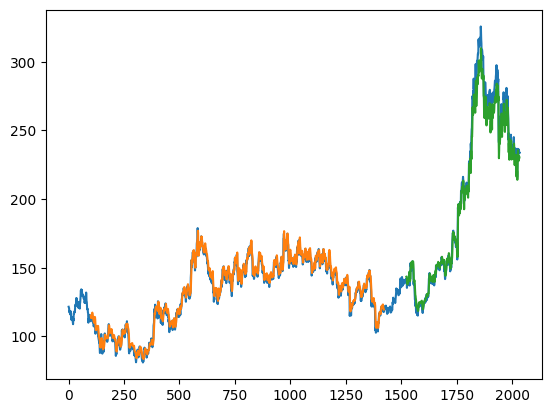

In [23]:
### Here, We Visualising the Predictions:
look_back = 100
train_num_pyredict_plot = np.empty_like(data_close)
train_num_pyredict_plot[:, :] = np.nan
train_num_pyredict_plot[look_back : len(train_predict) + look_back, :] = train_predict
test_predict_plot = np.empty_like(data_close)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1 : len(data_close) - 1, :] = test_predict
plt.plot(scaler.inverse_transform(data_close))
plt.plot(train_num_pyredict_plot)
plt.plot(test_predict_plot)
plt.show()

Here, 
* Green indicates the predicted (test) data.
* Orange indicates the trained data.
* Blue indicates the complete data.

In [24]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
len(stock)

2035

In [25]:
### Finally, We Get The Future Prediction Model:
x_inum_pyut=test[307:].reshape(1, -1)
x_inum_pyut.shape
temp_inum_pyut = list(x_inum_pyut)
temp_inum_pyut = temp_inum_pyut[0].tolist()
temp_inum_pyut = list(x_inum_pyut)
temp_inum_pyut = temp_inum_pyut[0].tolist()

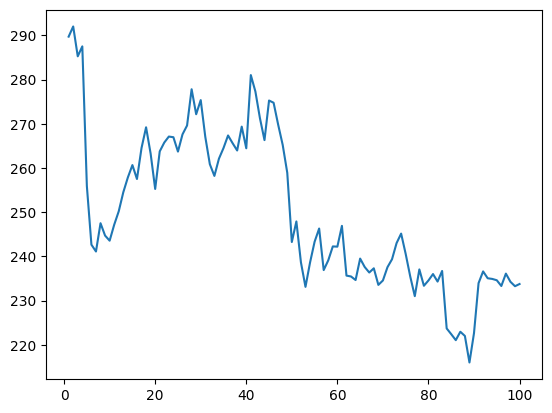

In [26]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)
plt.plot(day_new, scaler.inverse_transform(data_close[1935 : ]))